# 10. Convolutional neural networks

In this assignment you'll use a photo-Z dataset acquired from the observations of the SDSS telescope located in New Mexico. The goal is to predict redshifts from multiband images of galaxies. As a warmup you'll work with the SVHN dataset.

**<font color='red'>[WARN]:</font> For this assignment you'll need significantly more computational power compared to previous assignments! If you don't have a CUDA-capable GPU with >4Gb VRAM and >8Gb RAM, then you're advised to work on Google Colab!**

${\bf \text{Thank you for separating the markdown cells for each task description!}}$


Even though I have everything required for local workflow, for some reason the keras-extra-dataset is not being loaded. I wasted some hefty amount of time on the correct installing of CUDA Toolkits, cudnn an tensorflow which in the and could have made me happy as I have a stronger graphics card. In the end, I will work on Google Colab...

In [1]:
import numpy as np
import pandas as pd

import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import sys
import os
import pathlib
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics

from os import listdir
from os.path import isfile, join

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.__version__)
print(dir(tf.feature_column))

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 214687912204403806
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6069138282973185403
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]
2.7.0
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'bucketized_column', 'categorical_column_with_hash_bucket', 'categorical_column_with_identity', 'categorical_column_with_vocabulary_file', 'categorical_column_with_vocabulary_list', 'crossed_column', 'embedding_column', 'indicator_column', 'make_parse_example_spec', 'numeric_column', 'sequence_categorical_column_with_hash_bucket', 'sequence_categorical_column_with_identity', 'sequence_categorical_column_with_vocabulary_file', 'sequence_categorical_column_with_voca

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!pip install extra-keras-datasets

In [4]:
from extra_keras_datasets import svhn

### 1. Load the Street View House Numbers (SVHN) dataset

-   Download the SVHN database and load the train and test datasets!
    There are multiple ways to do this. The easiest one is probably to install
    and use the `extra-keras-datasets` Python package. You need to use the
    standard/normal SVHN dataset only and NOT the one titled as `extra`!
    (Of course, if you have enough RAM and VRAM, you can work with that one
    too, if you want...)
-   Preprocess the downloaded data if needed to be able to use it for training
    and testing!
-   Normalize the pixel values into the interval of [0,1]!
-   How many and what classes do we have in the dataset? How many train and test
    examples do we have?
-   What are the dimensions of the images?
-   Show some images randomly from the dataset!
-   Make one-hot encoding for the labels!

In [5]:
(X_train, y_train), (X_test, y_test)  = svhn.load_data(type='normal')
print(X_train.shape); print(y_train.shape); print(X_test.shape); print(y_test.shape)

INFO:root:Loading dataset = svhn


(73257, 32, 32, 3)
(73257,)
(26032, 32, 32, 3)
(26032,)


So it seems like these are 32x32 RGB picturs tht have a 75-25 train-test plit. Quite a lot pictures though...

In [6]:
26032 / ( 26032 + 73257)

0.2621841291583156

In [7]:
np.unique(X_train)  #let's see values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

There are no NaNs inside, but they need normaisation.

In [8]:
X_train = X_train / 255
X_test = X_test / 255


np.unique(X_train)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313725, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.0745098 ,
       0.07843137, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196078, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941176, 0.13333333,
       0.1372549 , 0.14117647, 0.14509804, 0.14901961, 0.15294118,
       0.15686275, 0.16078431, 0.16470588, 0.16862745, 0.17254902,
       0.17647059, 0.18039216, 0.18431373, 0.18823529, 0.19215686,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568627, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313725, 0.24705882, 0.25098039,
       0.25490196, 0.25882353, 0.2627451 , 0.26666667, 0.27058824,
       0.2745098 , 0.27843137, 0.28235294, 0.28627451, 0.29019

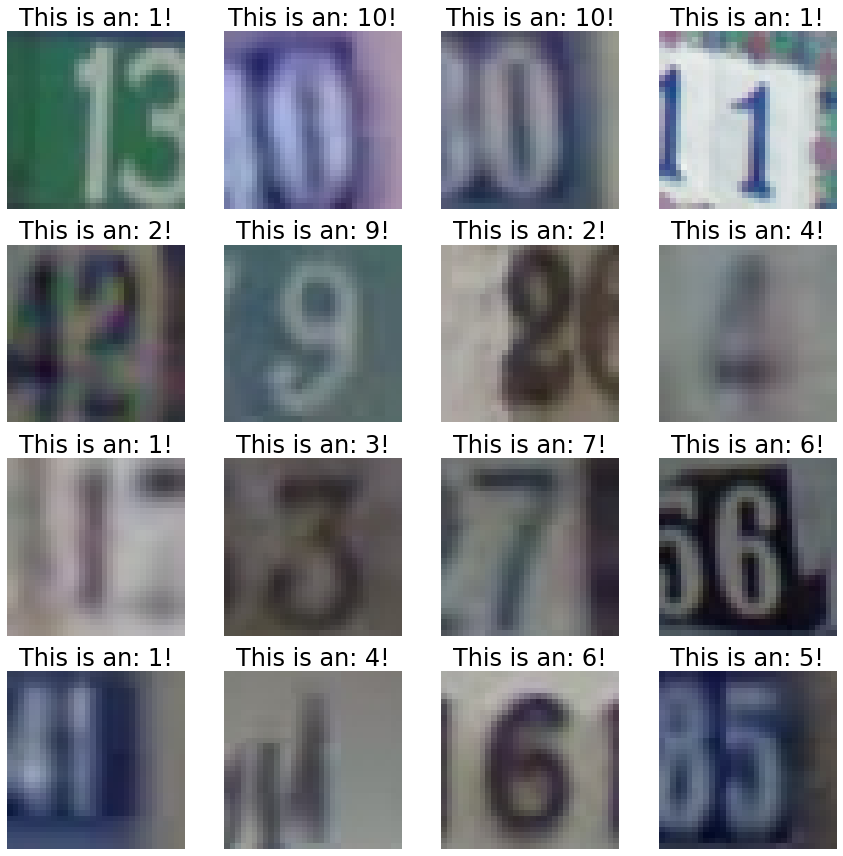

In [9]:
#lets see what are these!
#find 16 indices to be pulled from the data...
ncols, nrows = 4,4
n = ncols * nrows
random_indexes = random.sample(list(np.arange(len(X_train))), n)
random_samples = X_train[random_indexes]
random_targets = y_train[random_indexes]

#print(random_samples)

fig, axes = plt.subplots(ncols,nrows, figsize=(ncols*3,nrows*3))
for i in range(len(axes)):
  for j in range(len(axes[i])):
    axes[i,j].set_title("This is an: {0}!".format(random_targets[i*len(axes[i]) + j]), fontsize=24)
    axes[i,j].imshow(np.array(random_samples[i*len(axes[i]) + j] * 255, dtype=np.uint8))
    axes[i,j].set_axis_off()


fig.tight_layout()
plt.show()

In [10]:
np.unique(y_train), np.unique(y_test)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

In [11]:
#index 10 is out of bounds for axis 1 with size 10
y_train_oh = tf.keras.utils.to_categorical(y_train-1,10)
y_test_oh = tf.keras.utils.to_categorical(y_test-1,10)

print(y_train_oh[0],"\n", y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 1


So the encoding is good too! Let's continue.

### 2. Create a convolutional neural network for the SVHN dataset

-   Train the following network on the training set and generate
    prediction for the test images:
    ```
          > conv2D, 16 kernels, kernel size = (3,3), valid padding, relu actvation
          > conv2D, 16 kernels, kernel size = (3,3), valid padding, relu actvation
          > maxpooling kernel size = (2,2)
          > conv2D, 32 kernels, kernel size = (3,3), valid padding, relu actvation
          > conv2D, 32 kernels, kernel size = (3,3), valid padding, relu actvation
          > maxpooling pool size = (2,2) strides = (2,2)
          > flatten
          > dense, 10 neurons, softmax activation
    ```
    -   Use Adam optimizer with default parameters
    -   Use categorical crossentropy as loss function
    -   Compile the model
    -   Print out a summary of the model
    -   Train the CNN on the training data for 25 epochs with batch size
        of 64
    -   Use the test data as validation data

-   Calculate the categorical cross-entropy loss and the accuracy!
    **<font color='green'>[HINT]:</font>** you should get at least $\approx$ 80-90%
    accuracy.
-   Plot the training and the validation loss and accuracy on the same plot!
    Do we experience overfitting?
-   Show the confusion matrix of the predictions!

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [13]:
#okey, let's use what you have provided for me!
model = tf.keras.Sequential()
model.add(Conv2D(16, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(16, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
history = model.fit(x=X_train, y=y_train_oh,
                    batch_size=1024, epochs=25,
                    validation_data=(X_test, y_test_oh))

Train on 73257 samples, validate on 26032 samples
Epoch 1/25
73257/73257 [==============================] - ETA: 0s - loss: 2.1846 - accuracy: 0.2157

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


73257/73257 [==============================] - 15s 202us/sample - loss: 2.1846 - accuracy: 0.2157 - val_loss: 1.8413 - val_accuracy: 0.4082
Epoch 2/25
73257/73257 [==============================] - 6s 83us/sample - loss: 1.2138 - accuracy: 0.6320 - val_loss: 0.8295 - val_accuracy: 0.7698
Epoch 3/25
73257/73257 [==============================] - 6s 83us/sample - loss: 0.7289 - accuracy: 0.7906 - val_loss: 0.6962 - val_accuracy: 0.8082
Epoch 4/25
73257/73257 [==============================] - 6s 83us/sample - loss: 0.6360 - accuracy: 0.8203 - val_loss: 0.6513 - val_accuracy: 0.8215
Epoch 5/25
73257/73257 [==============================] - 6s 83us/sample - loss: 0.5857 - accuracy: 0.8351 - val_loss: 0.6256 - val_accuracy: 0.8321
Epoch 6/25
73257/73257 [==============================] - 6s 83us/sample - loss: 0.5533 - accuracy: 0.8444 - val_loss: 0.6003 - val_accuracy: 0.8386
Epoch 7/25
73257/73257 [==============================] - 6s 82us/sample - loss: 0.5317 - accuracy: 0.8510 - val_lo

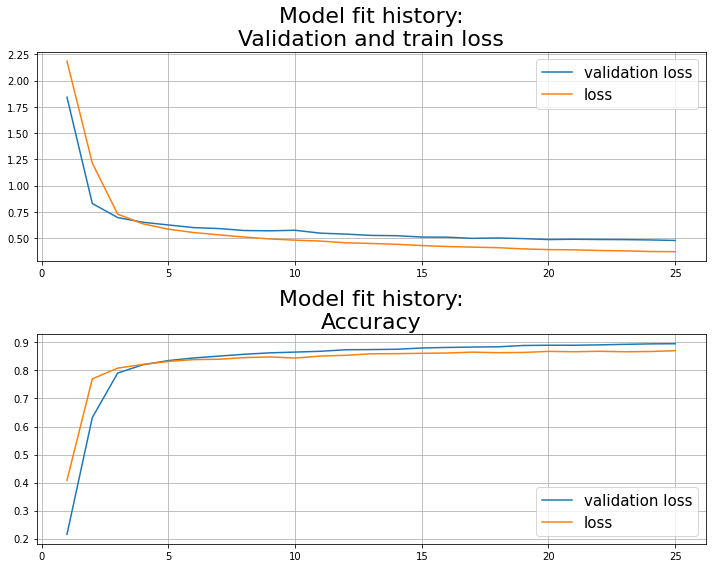

In [16]:
fig,ax = plt.subplots(2,1,figsize=(10,8))

ax[0].set_title('Model fit history:\nValidation and train loss', fontsize=22)
ax[0].plot(np.arange(25)+1, history.history['val_loss'], label='validation loss')
ax[0].plot(np.arange(25)+1, history.history['loss'], label='loss')
ax[0].legend(loc='best', fontsize=15)

ax[1].set_title('Model fit history:\nAccuracy', fontsize=22)
ax[1].plot(np.arange(25)+1, history.history['accuracy'], label='validation loss')
ax[1].plot(np.arange(25)+1, history.history['val_accuracy'], label='loss')
ax[1].legend(loc='best', fontsize=15)

ax[0].grid()
ax[1].grid()
fig.tight_layout()
plt.show()

In [17]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred[0])  #same trick like last time: argmax
y_pred0 = np.argmax(y_pred, axis=1)  #axis=1 -> each row
y_pred0 = y_pred0 + 1                 #to get the same encoding i need this
print(y_pred0[0])

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(26032, 10)
[1.1538271e-03 7.7992777e-04 7.4624069e-02 2.2679146e-03 8.5802048e-01
 3.3063684e-02 1.7679019e-02 6.2693283e-03 6.1176210e-03 2.4058854e-05]
5


In [18]:
def confusion_m_plot2(y1,y2,title):
    C_MY = metrics.confusion_matrix(y1, y2)
    display(C_MY)

    fig,ax = plt.subplots(1,1,figsize=(10,10))

    ax.set_xticks(np.arange(0,len(C_MY[0,:])))            #class ticks place
    ax.set_yticks(np.arange(0,len(C_MY[:,0])))            #survived ticks place
    ax_x = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]                           #class tick labels
    ax_y = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]                           #survived tick labels
    ax.set_xticklabels(ax_x, fontsize=18)
    ax.set_yticklabels(ax_y, fontsize=18)


    ax.set_title(title, fontsize=20)
    im1 = ax.imshow(C_MY, cmap="gray")

    for i in range(0,len(C_MY)):
        for j in range(0,len(C_MY[0])):
            color0="black"
            if(int(round(C_MY[i,j])) < int(round(np.max(C_MY)))*0.7):
                color0 = "white"
            text = ax.text(j, i, str(C_MY[i, j]),
                           ha="center", va="center", color=color0, fontsize=21)    

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')        

    fig.tight_layout()

    plt.show()

array([[4693,   56,   83,   81,   15,   13,   69,   20,    8,   61],
       [  39, 3767,  124,   37,   36,   12,   58,   22,   43,   11],
       [  67,   70, 2413,   24,  102,   20,   10,   51,  115,   10],
       [  75,   48,   55, 2224,   18,   22,   13,   17,   30,   21],
       [  23,   25,  148,   25, 2067,   47,    3,   19,   22,    5],
       [  33,   17,   95,   35,  117, 1558,   10,   43,   17,   52],
       [  93,   63,   48,    6,   20,    7, 1754,    4,   18,    6],
       [  16,   33,  114,   19,   54,   66,    5, 1289,   40,   24],
       [  17,   70,   39,    9,   26,    9,   14,   21, 1352,   38],
       [  22,   31,   29,    8,    6,   39,   16,   12,   41, 1540]])

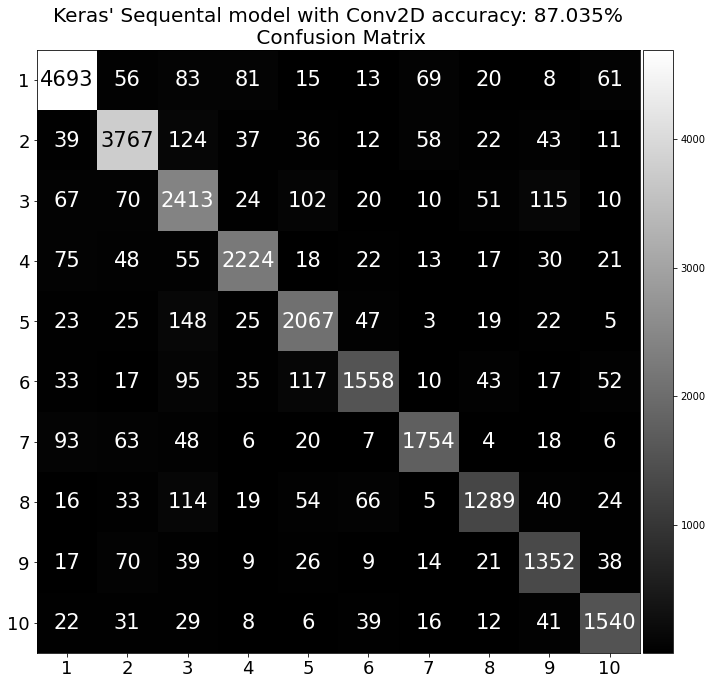

In [19]:
#confusion matrix
pred_vals = np.zeros(len(y_pred))
mask = y_test == -1
for i in range(len(y_pred)):
    pred_vals[i] = y_pred[i].argmax()+1
    mask[i] = y_test[i] == pred_vals[i] 
_ , accs = np.unique(mask, return_counts=True)
accuracy = accs[1] / (accs[0]+ accs[1])
confusion_m_plot2(y_test,
                  pred_vals,
                  "Keras' Sequental model with Conv2D accuracy: {0:.3f}%\n Confusion Matrix".format(accuracy*100))

### 3. Load the Sload Digital Sky Survey (SDSS) Dataset

You can download the dataset from Kaggle via
[this link](https://www.kaggle.com/masterdesky/multiband-photoz-sdss-dr16).

-   Download the images from Kaggle (~10'000 images total) 
-   Preprocess the images similarly to the SVHN dataset if needed! (Normalize
    pixel values to [0,1], etc.)
-   What are the dimensions of the images?
-   Show 15 images randomly from the dataset!
-   Create a train-test-validation split using `train_test_split` from `sklearn`
    where the test size is $0.33$ and the validation size is $0.2$
    -   Set a random seed
    -   Print the number of images in each of these sets after you've created
        them

In [20]:
#!unzip /content/drive/MyDrive/Colab/datamining/hw10/data/archive.zip

In [21]:
path_to = '../content/drive/MyDrive/Colab/datamining/hw10/data/'             #unneeded
df = pd.read_csv('skyserver_photoZ_data_DR16.csv')  #i used specific names for specific data... now its going to be df
df.info()   #it seems fine

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9847 entries, 0 to 9846
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   specObjID  9847 non-null   int64  
 1   ra         9847 non-null   float64
 2   dec        9847 non-null   float64
 3   z          9847 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 307.8 KB


In [22]:
df.iloc[0]

specObjID    5.457255e+18
ra           1.799457e+02
dec          5.601128e+00
z            6.115918e-01
Name: 0, dtype: float64

After looking at the images, the ids actually make them aligned to the targets...!

In [23]:
# Load in the images
pics = []
for filepath in os.listdir('images/'):
    pics.append(cv2.imread('images/{0}'.format(filepath),1))
pics = np.array(pics)
print(pics.shape)

(9847, 96, 96, 3)


So now they are 96 x 96 RGB pictures...

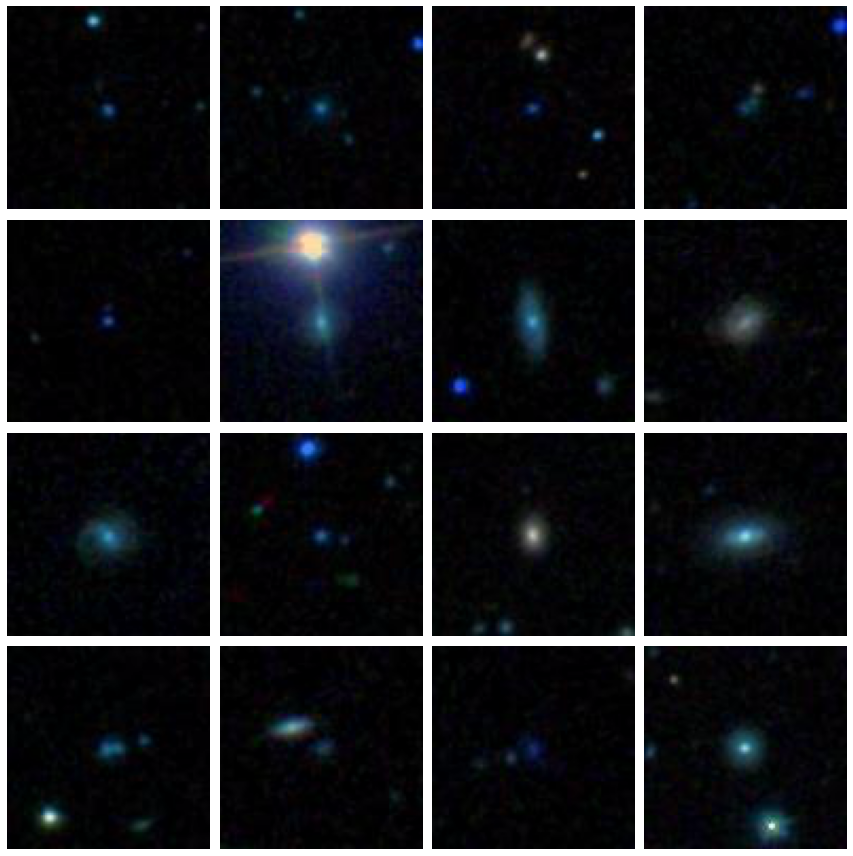

In [24]:
#lets see what are these!
#find 16 indices to be pulled from the data...
ncols, nrows = 4,4
n = ncols * nrows
random_indexes = random.sample(list(np.arange(len(pics))), n)
random_samples = pics[random_indexes]


#print(random_samples)

fig, axes = plt.subplots(ncols,nrows, figsize=(ncols*3,nrows*3))
for i in range(len(axes)):
  for j in range(len(axes[i])):
    axes[i,j].imshow(random_samples[i*len(axes[i]) + j])
    axes[i,j].set_axis_off()


fig.tight_layout()
plt.show()

In [25]:
pics = pics / np.max(pics)
print(np.max(pics))

1.0


Here I need train, test and validation with train_test_split. This means I will split first to train, nottran and then I will split nottrain to valid end test. 33% test, 20% validation, 47% train!

In [26]:
X_trainz, X_nottestz, y_trainz, y_nottestz = train_test_split(pics, df['z'].values, test_size=0.53,random_state=421)
X_testz, X_validz, y_testz, y_validz = train_test_split(X_nottestz,y_nottestz, test_size=0.2/0.53, random_state=421)

In [29]:
print('Pictures in X_train:', X_trainz.shape[0])
print('Pictures in y_train:', y_trainz.shape)
print('Pictures in X_valid:',X_validz.shape[0])
print('Pictures in y_valid:', y_validz.shape)
print('Pictures in X_test:', X_testz.shape[0])
print('Pictures in y_test:', y_testz.shape)

Pictures in X_train: 4628
Pictures in y_train: (4628,)
Pictures in X_valid: 1970
Pictures in y_valid: (1970,)
Pictures in X_test: 3249
Pictures in y_test: (3249,)


Okey, everything is prepared!

### 4. Create a convolutional neural network for the SDSS dataset

-   Train the following network on the training set and generate
    prediction for the test images:
    ```
          > conv2D, 32 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > conv2D, 32 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > maxpooling pool size = (2,2), strides = (2,2)
          
          > conv2D, 64 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > conv2D, 64 kernels, kernel size = (1,1), same padding
          > batch normalization
          > relu actvation
          > conv2D, 64 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > maxpooling pool size = (2,2), strides = (2,2)
          
          > global pooling
          > dense, 1 neuron, no activation
    ```

    -   Use Adam optimizer with default parameters
    -   Use mean squared error as loss function
    -   Compile the model
    -   Print out a summary of the model
    -   Use the created validation set as validation during the training
    -   Train the CNN on the training data for 25 epochs with batch size
        of 64

-   Calculate and print out the final accuracy using the R2 score!

In [31]:
from tensorflow.keras import activations

In [32]:
#as i see it, this wil predict values in a continous interval...
model = tf.keras.Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(Conv2D(64, kernel_size=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(tf.keras.layers.GlobalMaxPooling2D())
model.add(Dense(1, activation=None))

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [35]:
#9-10 thousand rows means i could do a batchsize of 64 or 128...
history = model.fit(x=X_trainz, y=y_trainz,
                    batch_size=128, epochs=25,
                    validation_data=(X_validz, y_validz))

Train on 4628 samples, validate on 1970 samples
Epoch 1/25
4628/4628 [==============================] - ETA: 0s - loss: 1.6355 - accuracy: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4628/4628 [==============================] - 13s 3ms/sample - loss: 1.6355 - accuracy: 0.0000e+00 - val_loss: 10.2925 - val_accuracy: 0.0000e+00
Epoch 2/25
4628/4628 [==============================] - 10s 2ms/sample - loss: 0.1770 - accuracy: 0.0000e+00 - val_loss: 6.1099 - val_accuracy: 0.0000e+00
Epoch 3/25
4628/4628 [==============================] - 10s 2ms/sample - loss: 0.1411 - accuracy: 0.0000e+00 - val_loss: 2.8398 - val_accuracy: 0.0000e+00
Epoch 4/25
4628/4628 [==============================] - 10s 2ms/sample - loss: 0.1155 - accuracy: 0.0000e+00 - val_loss: 1.2081 - val_accuracy: 0.0000e+00
Epoch 5/25
4628/4628 [==============================] - 10s 2ms/sample - loss: 0.0961 - accuracy: 0.0000e+00 - val_loss: 0.5266 - val_accuracy: 0.0000e+00
Epoch 6/25
4628/4628 [==============================] - 10s 2ms/sample - loss: 0.0838 - accuracy: 0.0000e+00 - val_loss: 0.3062 - val_accuracy: 0.0000e+00
Epoch 7/25
4628/4628 [==============================] - 10s 2ms/sample - loss: 0

In [37]:
y_predz = model.predict(X_testz)[:,0]

In [39]:
metrics.r2_score(y_testz,y_predz)

-1.7282932648441096

So this means it found some inverse relation?

### 5. Evaluate performance

-   Plot the training and the validation loss on the same plot!
-   Show the predicted values vs the actual labels on a plot!
-   Where does the model make mistakes? Try to plot the images corresponding to
    some outlier values!

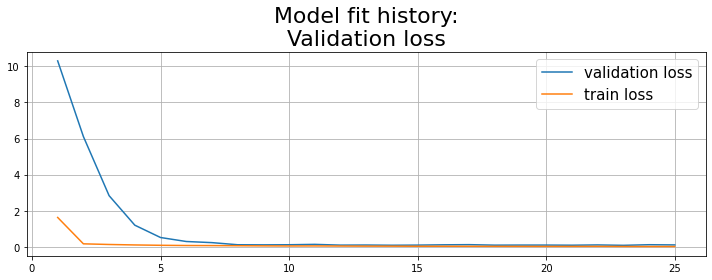

In [45]:
fig,ax = plt.subplots(1,1,figsize=(10,4))

ax.set_title('Model fit history:\nValidation loss', fontsize=22)
ax.plot(np.arange(25)+1, history.history['val_loss'], label='validation loss')
ax.plot(np.arange(25)+1, history.history['loss'], label='train loss')
ax.legend(loc='best', fontsize=15)

ax.grid()
fig.tight_layout()
plt.show()

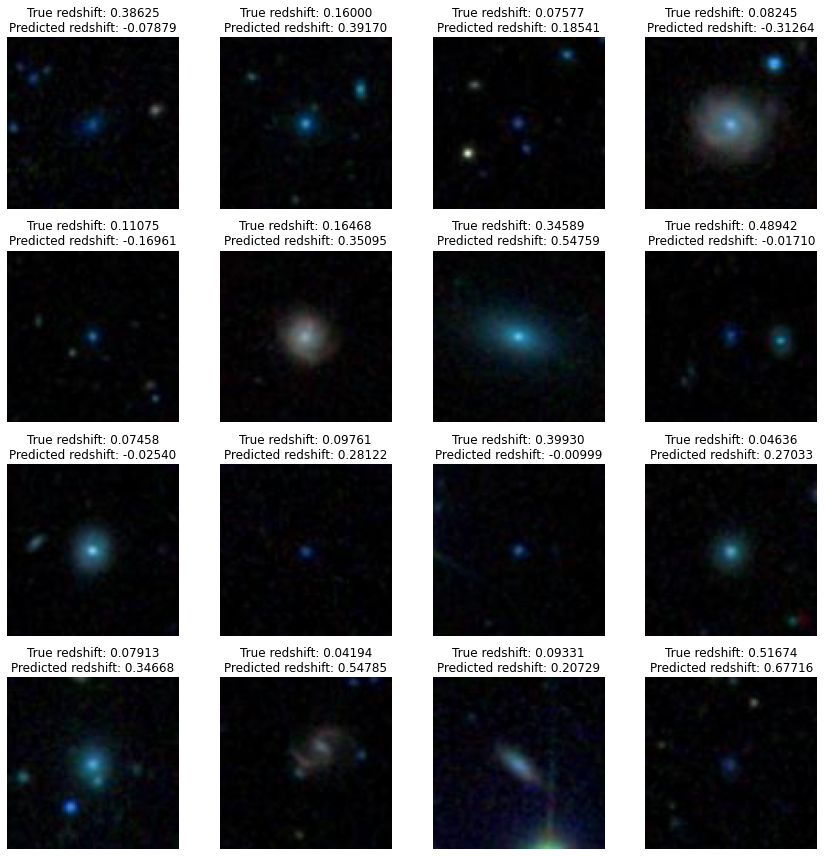

In [54]:
#lets see what are these!
#find 16 indices to be pulled from the data...
ncols, nrows = 4,4
n = ncols * nrows

#sample indices randomly,
#get the data accordingly!
random_indexes = random.sample(list(np.arange(len(X_testz))), n)
random_samples = X_testz[random_indexes]
random_preds =   y_predz[random_indexes]
random_trues =   y_testz[random_indexes]



#print(random_samples)

fig, axes = plt.subplots(ncols,nrows, figsize=(ncols*3,nrows*3))
for i in range(len(axes)):
  for j in range(len(axes[i])):
    axes[i,j].set_title("True redshift: {0:.5f}\nPredicted redshift: {1:.5f}".format(random_trues[i*len(axes[i]) + j], random_preds[i*len(axes[i]) + j]))
    axes[i,j].imshow(np.array(random_samples[i*len(axes[i]) + j]*255, dtype=np.uint8))
    axes[i,j].set_axis_off()


fig.tight_layout()
plt.show()

There are already a couple of "big" mistakes. Everytime I choosed 16 test samples, I always found very bad ones. Maye the mean square method is not good for this. Let's see a couple of stats of the test data. It seems like the darker or more spread out shaped samples come with a higher difference.

In [61]:
from scipy.stats import moment,skew,kurtosis

In [62]:
#the idea is that if there is some kind of distribution in redshift, the predicted and true values should have the same moments, or almost
print("The averages are: {0:.4f}\t{1:.4f}".format( np.mean(y_predz), np.mean(y_testz) ) ) 
print("The scatters are: {0:.4f}\t{1:.4f}".format( np.var(y_predz)**(1/2), np.var(y_testz)**(1/2) ) ) 

The averages are: 0.1525	0.3146
The scatters are: 0.2222	0.2070


These seem to be quite different...

### 6. Train an other CNN

-   The previous architecture can be further improved.
-   Come up with an architecture that can achieve more than 80-85% accuracy on 
    the test set if the accuracy metric is the R2 score!
    -   You can use any tool for this task.
    -   Remember that there are different losses and optimizers, early stopping,
        regularization, etc. that can be useful for you. You can find more about 
        these eg. in the
        [tensorflow/keras documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols).
    -   Don't forget that you can add more layers to the model and train for
        more epochs too... :)
-   Print out the summary of this model!
-   Plot the loss curves for this model too!